In [2]:
import pandas as pd
import numpy as np 
import warnings
import sys
sys.path.append("../HistoricalData/")
#from getData import get_data

warnings.filterwarnings('ignore')

from math import sin, cos, radians, pi
import time
from collections import defaultdict

In [4]:
UP_LEFT = (38.008050, -122.536985)    
UP_RIGHT = (38.008050, -122.186437)   
DOWN_RIGHT = (37.701933, -122.186437) 
DOWN_LEFT = (37.701933, -122.536985)  
START_DATE = '2019/09/01' 
END_DATE = '2019/09/02'   
START_HOUR = '0'        
END_HOUR = '24'           

df = get_data(UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, START_DATE, END_DATE, START_HOUR, END_HOUR, 'Monthly')

In [18]:
df['wind_direction'] = df['wind_direction'].map(lambda x: x if x is not None else 0)

# fill in no wind times
df['wind_speed'].fillna(0, inplace = True)
df['wind_direction'].replace('', 0, inplace = True)

# change VRB to 0
vrb = df[df.wind_direction == "VRB"].index
df.loc[vrb, 'wind_direction'] = 0
df.loc[vrb, 'wind_speed'] = 0

In [19]:
df['wind_x'] = df.apply(lambda x: x.wind_speed * cos(radians(int(x.wind_direction))), axis = 1)
df['wind_y'] = df.apply(lambda x: x.wind_speed * sin(radians(int(x.wind_direction))), axis = 1)

brainstorming features ...
- temperature
- elevation
- humidity
- ndvi
- features of neighboring squares

In [20]:
# features ...
df[[col for col in df.columns if "wind" in col]].head()

,wind_data,wind_direction,wind_speed,variable_winds,variable_wind_info,wind_compass,wind_x,wind_y
0,1.0,280,7.0,0.0,,West,1.215537,-6.893654
1,1.0,290,7.0,0.0,,ERROR,2.394141,-6.577848
2,1.0,280,8.0,0.0,,West,1.389185,-7.878462
3,1.0,280,8.0,0.0,,West,1.389185,-7.878462
4,1.0,280,8.0,0.0,,West,1.389185,-7.878462


In [21]:
sensor_locs = df.apply(lambda x: (x.lat, x.lon), axis  = 1).drop_duplicates()

In [24]:
sensor_locs.to_csv("sensor_locs.csv")

In [25]:
df.to_csv("chkpnt.csv", index = False)

## adding grid

In [2]:
df = pd.read_csv("chkpnt.csv")

In [6]:
boxes = pd.read_csv("boxes.csv")

In [7]:
boxes.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,elevation
0,37.701933,37.705487,-122.536985,-122.532493,0,0,37.703710,-122.534739,-18.298014
1,37.705487,37.709040,-122.536985,-122.532493,0,1,37.707263,-122.534739,-17.159355
2,37.709040,37.712593,-122.536985,-122.532493,0,2,37.710817,-122.534739,-15.904209
3,37.712593,37.716147,-122.536985,-122.532493,0,3,37.714370,-122.534739,-14.731192
4,37.716147,37.719700,-122.536985,-122.532493,0,4,37.717923,-122.534739,-13.759017


In [28]:
boxes[['x', 'y']].max()

x    78
y    86
dtype: int64

In [30]:
# surely there must be a faster way, this is slow as shit
def get_coords(line):
    box = boxes[(boxes.min_lat < line.lat) & (boxes.max_lat > line.lat) & 
                (boxes.min_lon < line.lon) & (boxes.max_lon > line.lon)]
    assert box.shape[0] == 1
    return box.iloc[0, 4], box.iloc[0, 5] # x,y

In [31]:
df['xy'] = df.apply(get_coords, axis = 1)

wow this is really slow

In [33]:
df['xy'].nunique()

163

In [42]:
df.to_csv("chkpnt.csv", index = False)

## adding satellite data

In [3]:
df = pd.read_csv("chkpnt.csv")

In [4]:
import rasterio

dataset_a = rasterio.open('new_sent_a.tif') # north half of sentinel imagery
dataset_b = rasterio.open('new_sent_b.tif') # south half of sentinel imagery
ndvi = rasterio.open("new_ndvi.tif") # normalized vegetation index

In [5]:
dataset_a.bounds, dataset_b.bounds

(BoundingBox(left=-123.00023047979296, bottom=37.85289286316522, right=-121.73509612712401, top=38.84899848338563),
 BoundingBox(left=-123.00022763545473, bottom=36.951385650931456, right=-121.75063386741522, top=37.94758957156296))

In [6]:
banda1 = dataset_a.read(1)
banda2 = dataset_a.read(2)
banda3 = dataset_a.read(3)
bandb1 = dataset_b.read(1)
bandb2 = dataset_b.read(2)
bandb3 = dataset_b.read(3)
band_n = ndvi.read(1)

In [7]:
def get_sentinel(line):
    
    ## use only on unique
    
    # if lat >  ...
    if line.lat > 37.94758957156296:
        # use dataset a, north half
        r = banda1
        g = banda2
        b = banda3
        
        # 40-44 units corresponds to about 1 km
        mid_row, mid_col = dataset_a.index(line.lon, line.lat)
        
        return np.dstack((r[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          g[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          b[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20]))
                
        
    else:
        # use dataset b

        r = bandb1
        g = bandb2
        b = bandb3
        
        mid_row, mid_col = dataset_b.index(line.lon, line.lat)
        
        return np.dstack((r[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          g[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          b[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20]))
        
    
def get_ndvi(line):
    # get ndvi
    row, col = ndvi.index(line.lon, line.lat)
    
    return band_n[row,col]

In [8]:
geo_features = df[['sensor_id', 'lat', 'lon']].drop_duplicates(subset=['sensor_id']).reset_index(drop = True)
geo_features.shape

(185, 3)

In [9]:
geo_features['ndvi'] = geo_features.apply(get_ndvi, axis = 1)

In [10]:
geo_features['image'] = geo_features.apply(get_sentinel, axis = 1)

In [11]:
geo_features = geo_features.reset_index().set_index('sensor_id')

In [12]:
dataset_a.close()
dataset_b.close()
ndvi.close()

In [13]:
geo_features.head()

,index,lat,lon,ndvi,image
sensor_id,,,,,
16939,0,37.722440,-122.439302,3327,"[[[118, 130, 92], [115, 127, 89], [106, 118, 7..."
16919,1,37.722456,-122.439390,3327,"[[[113, 125, 85], [118, 130, 92], [115, 127, 8..."
16931,2,37.722417,-122.439245,3327,"[[[118, 130, 92], [115, 127, 89], [106, 118, 7..."
19173,3,37.722383,-122.439227,3327,"[[[118, 130, 92], [115, 127, 89], [106, 118, 7..."
16947,4,37.722391,-122.439178,3327,"[[[118, 130, 92], [115, 127, 89], [106, 118, 7..."


In [36]:
geo_features.ndvi.describe()

count     185.000000
mean     3389.497297
std      1791.196039
min     -2000.000000
25%      2197.000000
50%      2998.000000
75%      4602.000000
max      7597.000000
Name: ndvi, dtype: float64

## potential features (thinking out loud)
\* indicates features we don't currently have 

- point, static:
  - elevation
  - vegetation*
  - population*
  - road coverage* (could get satellite imagery, do conv)
- point, dynamic
  - ???
  - meteorology*
- neighbors, static
  - everything under static
- neighbors, dynamic
  - sensor readings
  - weather*
- area-wide, dynamic
  - meteorology -- wind speed, wind direction
  - other meteorology -- temp, pressure, humidity*
  - EPA sensor
  - better EPA sensor (currently only have nearest sensor, not weighted by distance)
  - time of day
  - day of week
  
  

## Model training, I guess

In [33]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Conv2D, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.layers import Dense, Reshape, Activation, MaxPooling2D, Flatten

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df['ndvi'] = df['sensor_id'].map(lambda x: geo_features.loc[x, 'ndvi'])

In [16]:
import ast
df['xy'] = df['xy'].map(lambda x: ast.literal_eval(x))

In [17]:
df['x'] = df['xy'].map(lambda x:x[0])
df['y'] = df['xy'].map(lambda x:x[1])

In [18]:
# preprocessing 10/31 -- faster neighbor look up
df['timestamp'] = pd.to_datetime(df.created_at, format = "%Y/%m/%dT%H:%M").map(lambda x: x.timestamp()/600)
df['time_space_id'] = df.apply(lambda x: f"{x.timestamp}_{x.x}_{x.y}", axis = 1)

In [19]:
target_var = '2_5um'

input_cols = ['sensor_id', target_var, # ref cols, not used as training, reading only for neighbors
              'time_space_id', # for trying to look up neighbors
              'hour', 'wkday', # categorical cols
              'epa_pm25_value','temperature', 'humidity',  'wind_x', 'wind_y', 'ndvi'] # numeric cols


X_train_and_dev, X_test, y_train_and_dev, y_test = train_test_split(df[input_cols], 
                                                                    df[target_var], 
                                                                    test_size=0.20, 
                                                                    random_state=42)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_and_dev, y_train_and_dev, test_size=0.125, random_state=42)

In [20]:
for col in ['epa_pm25_value', 'temperature', 'humidity']:
    v = X_train[col].mean()
    X_train[col].fillna(v, inplace = True)
    X_dev[col].fillna(v, inplace = True)

In [19]:
X_train.isnull().any()

sensor_id         False
2_5um             False
time_space_id     False
hour              False
wkday             False
epa_pm25_value    False
temperature       False
humidity          False
wind_x            False
wind_y            False
ndvi              False
dtype: bool

In [21]:
# four inputs ...

# categorical: weekday, hour
X_train_categorical = X_train[['hour', 'wkday']].to_numpy()
X_dev_categorical = X_dev[['hour', 'wkday']].to_numpy()

# continuous data (epa, humidity, temperature, wind_x, wind_y, ndvi)
X_train_num = X_train[['epa_pm25_value','temperature', 'humidity',  'wind_x', 'wind_y', 'ndvi']].to_numpy()
X_dev_num = X_dev[['epa_pm25_value','temperature', 'humidity',  'wind_x', 'wind_y', 'ndvi']].to_numpy()

# image

X_train_imgs = np.array([geo_features.loc[s_id, 'image'] for s_id in X_train['sensor_id']])
X_dev_imgs = np.array([geo_features.loc[s_id, 'image'] for s_id in X_dev['sensor_id']])

In [130]:
# OLD NEIGHBORS CODE -- VERY SLOW


# def get_neighbors(df, s_id, year, month, day, hour, minute, x,y):
    
#     # a faster way would probably be to build a look up table with sensor_ids on one axis
#     # and times along the other, but ...
#     # this will not scale well with a year of data
        
#     snapshot = df[(df.year == year) &
#                   (df.month == month) &
#                   (df.day == day) &
#                   (df.hour == hour) &
#                   (df.minute == minute) &
#                   (df.sensor_id != s_id) & 
#                   (df.x.isin(list(range(x-2,x+3)))) &
#                   (df.y.isin(list(range(y-2,y+3))))]
    
#     if snapshot.shape[0] == 0:
#         return np.zeros(12)
    
#     # sort by nearest neighbors
#     snapshot['dist'] = snapshot.apply(lambda d: ((d.x-x)**2 + (d.y-y)**2)**0.5, axis = 1)
#     neighbors = snapshot.sort_values(by=['dist'])['2_5um'].to_list()
    
    
#     if len(neighbors) > 12:
#         # lots of neighbors nearby, return the 12 closest
#         return np.array(neighbors[:12])
#     elif len(neighbors) == 12:
#         return np.array(neighbors)
#     else:
#         return np.pad(np.array(neighbors), (0, 12-len(neighbors)))
# import json
# with open("sensor_neighbors.json", "r") as f:
#     neighbor_lookup = json.load(f)

# t = []    

# def get_neighbors(train_df, sensor_id, created_at):
       
#     if str(sensor_id) not in neighbor_lookup:
#         return np.zeros(12)
    
#     if len(neighbor_lookup[str(sensor_id)]) == 0:
#         return np.zeros(12)
    
#     neighbors = [int(n) for n in neighbor_lookup[str(sensor_id)]]
        
#     snapshot = train_df[(train_df.created_at == created_at)][['sensor_id', '2_5um']]
        
#     snapshot = snapshot[snapshot.sensor_id.isin(neighbors)] 

#     if snapshot.shape[0] == 0:
#         return np.zeros(12)
    
#     near_values = snapshot['2_5um'].to_list()
    
#     if len(near_values) > 12:
#         # lots of neighbors nearby, return the 12 closest
#         return np.array(near_values[:12])
#     elif len(near_values) == 12:
#         return np.array(near_values)
#     else:
#         return np.pad(np.array(near_values), (0, 12-len(near_values)))

In [22]:
%%time
neighbor_lookup = defaultdict(list)
X_train.apply(lambda x: neighbor_lookup[x.time_space_id].append(x.name), axis = 1)

CPU times: user 11.7 s, sys: 200 ms, total: 11.9 s
Wall time: 11.9 s


138697    None
289772    None
79415     None
288024    None
141815    None
          ... 
349446    None
525561    None
691048    None
700739    None
249843    None
Length: 508403, dtype: object

In [23]:
## NEW NEIGHBORS CODE 10/31 -- SLOW-ISH BUT AT 90X FASTER THAN BEFORE


def get_neighbors_space(line, train_df):
    t, x, y = line.time_space_id.split("_")
    x = int(x)
    y = int(y)
    neighbors = np.zeros((24))
    
    c = 0
    for i in range(-2,3):
        for j in range(-2,3):
            if i == 0 and j == 0 : continue
            n = neighbor_lookup[f"{t}_{x+i}_{y+j}"] # get rows in train_df for that particular time-block
            
            if n:
                neighbors[c] = train_df.loc[n, '2_5um'].mean()
            c += 1
    
    return neighbors

In [24]:
%%time
X_train_neighbors = X_train.apply(lambda x: get_neighbors_space(x, X_train), axis =1)

CPU times: user 8min 17s, sys: 5.33 s, total: 8min 22s
Wall time: 8min 11s


In [25]:
X_train_neighbors = np.array(X_train_neighbors.to_list())

In [25]:
(np.count_nonzero(X_train_neighbors, axis = 0)) / X_train_neighbors.shape[0]

array([0.06304644, 0.08532208, 0.07564471, 0.0814649 , 0.05749376,
       0.04066656, 0.05477741, 0.05977935, 0.03200807, 0.10695649,
       0.07955303, 0.0707903 , 0.06765892, 0.11023342, 0.08624261,
       0.03200611, 0.05713578, 0.05563697, 0.0409852 , 0.05954922,
       0.08154358, 0.08547943, 0.08900026, 0.06336902])

In [26]:
%%time
X_dev_neighbors = X_dev.apply(lambda x: get_neighbors_space(x, X_train), axis =1)

CPU times: user 1min 19s, sys: 908 ms, total: 1min 20s
Wall time: 1min 18s


In [27]:
X_dev_neighbors = np.array(X_dev_neighbors.to_list())

10/31 update: old time was 70 minutes, 33 seconds

In [28]:
y_train = y_train.to_numpy()

In [29]:
y_dev = y_dev.to_numpy()

### Anyway, on to the actual model

In [33]:
#### INPUTS
img_in_ = Input(shape=(40,40,3), name='img_input')
hours_in_ = Input(shape=(1,), name = 'hrs_input')
wkdays_in_ = Input(shape=(1,), name = "wkdays_input")
nums_in_ = Input(shape=(6,), name='nums_input')
neighbs_in_ = Input(shape=(24,), name='neighbs_input')

#### IMAGERY
# input -> conv2d -> activation -> normalization -> 2x2 max pooling -> flatten
   
img_ = Conv2D(filters = 64, kernel_size = (5,5))(img_in_)
img_ = BatchNormalization(axis = -1)(img_)
img_ = Activation(activation='relu')(img_)
img_ = MaxPooling2D(pool_size=(2,2))(img_)

img_ = Conv2D(filters = 64, kernel_size = (3,3))(img_)
img_ = BatchNormalization(axis = -1)(img_)
img_ = Activation(activation='relu')(img_)
img_ = MaxPooling2D(pool_size=(2,2))(img_)

img_ = Flatten()(img_)

img_ = Dense(128, activation = 'relu')(img_)
img_ = Dropout(0.2)(img_)
img_ = Dense(16, activation = 'relu')(img_)

#### categorical data (weekday, hour)
# input -> [embedding_hour, embedding_weekday] -> concat -> 
hours_ = Embedding(input_dim = 24, output_dim = 4, input_length = 1)(hours_in_)
wkdays_ = Embedding(input_dim = 7, output_dim = 2, input_length = 1)(wkdays_in_)

# both are now is now [batch_size, 1, output_dim]
hours_ = Reshape((4,))(hours_)
wkdays_ = Reshape((2,))(wkdays_)
# both are now is now [batch_size,output_dim]

#### continuous data (epa, humidity, temperature, wind_x, wind_y, ndvi)
# input -> batch_norm
nums_ = BatchNormalization()(nums_in_)

### neighborhood data
#neighbs_ = BatchNormalization()(neighbs_in_)

#### everything together
x_ = Concatenate()([img_, hours_, wkdays_, nums_, neighbs_in_])

## FF time
x_ = Dense(128, activation = 'relu')(x_)
x_ = Dropout(0.2)(x_)
x_ = Dense(64, activation = 'relu')(x_)
x_ = Dropout(0.2)(x_)
output_ = Dense(1)(x_)

inputs = [img_in_, hours_in_, wkdays_in_, nums_in_, neighbs_in_]
model = Model(inputs = inputs, outputs = output_)

In [34]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','mape'])

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 36, 64)   4864        img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 36, 36, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 36, 36, 64)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

note to self, also try L2 regularization for some of the layers


In [183]:
# df.isnull().any()
X_train.isnull().any()


sensor_id         False
created_at        False
xy                False
x                 False
y                 False
2_5um             False
year              False
month             False
day               False
minute            False
hour              False
wkday             False
epa_pm25_value     True
temperature        True
humidity           True
wind_x            False
wind_y            False
ndvi              False
dtype: bool

In [37]:
# different run 10/31
history = model.fit(
    x=[X_train_imgs, X_train_categorical[:,0], X_train_categorical[:,1], X_train_num, X_train_neighbors],
    y=y_train,
    batch_size=512,
    epochs=2,
    verbose=1,
    validation_data=([X_dev_imgs, X_dev_categorical[:,0], X_dev_categorical[:,1], X_dev_num, X_dev_neighbors], y_dev),
    validation_freq=1
)

Train on 508403 samples, validate on 72630 samples
Epoch 1/2
508403/508403 [==============================] - 757s 1ms/sample - loss: 52.0247 - mse: 52.0248 - mape: 58028240.0000 - val_loss: 218.2554 - val_mse: 218.2554 - val_mape: 43985312.0000
Epoch 2/2
508403/508403 [==============================] - 753s 1ms/sample - loss: 50.4877 - mse: 50.4877 - mape: 45389728.0000 - val_loss: 215.0528 - val_mse: 215.0528 - val_mape: 95183568.0000


In [196]:
# run 10/30

# [img_in_, hours_in_, wkdays_in_, nums_in_, neighbs_in_]

history = model.fit(
    x=[X_train_imgs, X_train_categorical[:,0], X_train_categorical[:,1], X_train_num, X_train_neighbors],
    y=y_train,
    batch_size=512,
    epochs=6,
    verbose=1,
    initial_epoch = 1,
    validation_data=([X_dev_imgs, X_dev_categorical[:,0], X_dev_categorical[:,1], X_dev_num, X_dev_neighbors], y_dev),
    validation_freq=1
)

Train on 508403 samples, validate on 72630 samples
Epoch 2/6
508403/508403 [==============================] - 765s 2ms/sample - loss: 50.2355 - mse: 50.2355 - mape: 41419524.0000 - val_loss: 213.4076 - val_mse: 213.4076 - val_mape: 47107052.0000
Epoch 3/6
508403/508403 [==============================] - 756s 1ms/sample - loss: 49.9107 - mse: 49.9107 - mape: 39077512.0000 - val_loss: 212.8770 - val_mse: 212.8770 - val_mape: 46320992.0000
Epoch 4/6
508403/508403 [==============================] - 758s 1ms/sample - loss: 49.7064 - mse: 49.7064 - mape: 37057704.0000 - val_loss: 213.4588 - val_mse: 213.4588 - val_mape: 46742580.0000
Epoch 5/6
508403/508403 [==============================] - 753s 1ms/sample - loss: 49.3864 - mse: 49.3864 - mape: 37776616.0000 - val_loss: 212.4379 - val_mse: 212.4379 - val_mape: 37382352.0000
Epoch 6/6
508403/508403 [==============================] - 752s 1ms/sample - loss: 49.0735 - mse: 49.0735 - mape: 37863464.0000 - val_loss: 212.3936 - val_mse: 212.3935 

initial reactions: Not that great, vastly overfitting

In [ ]:
# keras.utils.plot_model(model, 'my_first_model.png')

## model tweaks, plus a new neighbors function that is much faster

In [68]:
print(type(X_train_categorical))
print(type(X_train_num))
print(type(X_train_imgs))
print(type(X_train_neighbors))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [69]:
print(type(X_dev_categorical))
print(type(X_dev_num))
print(type(X_dev_imgs))
print(type(X_dev_neighbors))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [94]:
#### INPUTS
img_in_ = Input(shape=(40,40,3), name='img_input')
hours_in_ = Input(shape=(1,), name = 'hrs_input')
wkdays_in_ = Input(shape=(1,), name = "wkdays_input")
nums_in_ = Input(shape=(6,), name='nums_input')
neighbs_in_ = Input(shape=(24,), name='neighbs_input')

#### IMAGERY
# input -> conv2d -> activation -> normalization -> 2x2 max pooling -> flatten
   
img_ = Conv2D(filters = 64, kernel_size = (5,5))(img_in_)
img_ = BatchNormalization(axis = -1)(img_)
img_ = Activation(activation='relu')(img_)
img_ = MaxPooling2D(pool_size=(2,2))(img_)

img_ = Conv2D(filters = 64, kernel_size = (3,3))(img_)
img_ = BatchNormalization(axis = -1)(img_)
img_ = Activation(activation='relu')(img_)
img_ = MaxPooling2D(pool_size=(2,2))(img_)

img_ = Flatten()(img_)

img_ = Dense(128, activation = 'relu')(img_)
img_ = Dropout(0.5)(img_) # changed
img_ = Dense(16, activation = 'relu')(img_)

#### categorical data (weekday, hour)
# input -> [embedding_hour, embedding_weekday] -> concat -> 
hours_ = Embedding(input_dim = 24, output_dim = 4, input_length = 1)(hours_in_)
wkdays_ = Embedding(input_dim = 7, output_dim = 2, input_length = 1)(wkdays_in_)

# both are now is now [batch_size, 1, output_dim]
hours_ = Reshape((4,))(hours_)
wkdays_ = Reshape((2,))(wkdays_)
# both are now is now [batch_size,output_dim]

#### continuous data (epa, humidity, temperature, wind_x, wind_y, ndvi)
# input -> batch_norm
nums_ = BatchNormalization()(nums_in_)

### neighborhood data
neighbs_ = BatchNormalization()(neighbs_in_)

#### everything together
x_ = Concatenate()([img_, hours_, wkdays_, nums_, neighbs_])

## FF time -- added regularization
x_ = Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(x_)
x_ = Dropout(0.2)(x_)
x_ = Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(x_)
x_ = Dropout(0.2)(x_)
output_ = Dense(1)(x_)

inputs = [img_in_, hours_in_, wkdays_in_, nums_in_, neighbs_in_]
big_model = Model(inputs = inputs, outputs = output_)

In [95]:
big_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mape'])

In [76]:
history = model.fit(
    x=[X_train_imgs, X_train_categorical[:,0], X_train_categorical[:,1], X_train_num, X_train_neighbors],
    y=y_train,
    batch_size=512,
    epochs=5,
    verbose=1,
    validation_data=([X_dev_imgs, X_dev_categorical[:,0], X_dev_categorical[:,1], X_dev_num, X_dev_neighbors], y_dev),
    validation_freq=1
)

Train on 508403 samples, validate on 72630 samples
Epoch 1/5
508403/508403 [==============================] - 774s 2ms/sample - loss: 58.2212 - mape: 65106892.0000 - val_loss: 218.5086 - val_mape: 89306552.0000
Epoch 2/5
508403/508403 [==============================] - 756s 1ms/sample - loss: 53.3409 - mape: 57489504.0000 - val_loss: 218.2457 - val_mape: 54979484.0000
Epoch 3/5
508403/508403 [==============================] - 792s 2ms/sample - loss: 52.2854 - mape: 54182068.0000 - val_loss: 217.1847 - val_mape: 100152552.0000
Epoch 4/5
508403/508403 [==============================] - 756s 1ms/sample - loss: 51.7191 - mape: 54194500.0000 - val_loss: 215.6083 - val_mape: 73922408.0000
Epoch 5/5
508403/508403 [==============================] - 758s 1ms/sample - loss: 51.3154 - mape: 53101976.0000 - val_loss: 215.0022 - val_mape: 47782808.0000


the other one was better, but both suck

prediction analysis on one of the models from earlier

In [39]:
X_dev_imgs = X_dev_imgs.astype(np.float16)

In [40]:
# predicted vs actual for dev
preds = model.predict(
    x = [X_dev_imgs, X_dev_categorical[:,0], X_dev_categorical[:,1], X_dev_num, X_dev_neighbors],
    batch_size = 512,
    verbose = 0
)

In [ ]:
# look at characteristics of highest pred loss

In [47]:
preds = preds.reshape((preds.shape[0],))

In [49]:
X_dev['loss'] = X_dev['2_5um'] - preds
X_dev['pred'] = preds

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

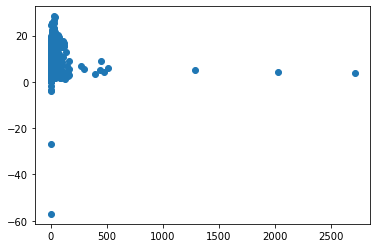

In [52]:
f, a = plt.subplots()
a.scatter(x = X_dev['2_5um'], y = X_dev['pred'])

(0, 30)

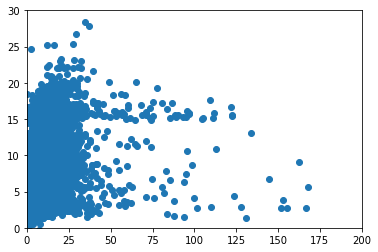

In [57]:
f, a = plt.subplots()
a.scatter(x = X_dev['2_5um'], y = X_dev['pred'])
a.set_xlim(0, 200)
a.set_ylim(0, 30)

(0, 25)

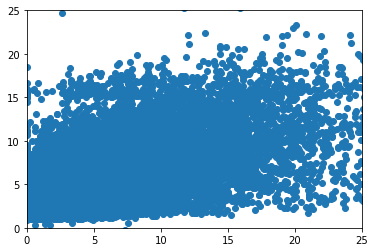

In [60]:
f, a = plt.subplots()
a.scatter(x = X_dev['2_5um'], y = X_dev['pred'])
a.set_xlim(0, 25)
a.set_ylim(0, 25)

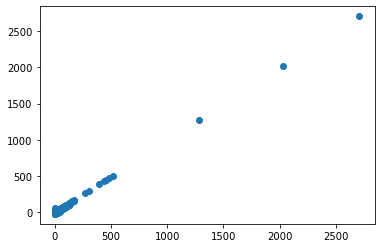

In [58]:
f, a = plt.subplots()
a.scatter(x = X_dev['2_5um'], y = X_dev['loss'])


so, a couple of absolutely mondo readings really hurt, I guess (the model still sucks)

In [ ]:
# so, a couple of absolutely mondo readings

(0, 200)

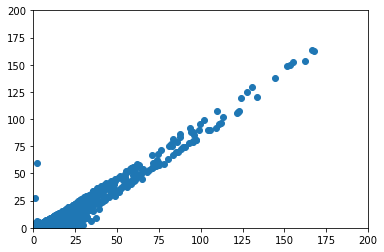

In [59]:
f, a = plt.subplots()
a.scatter(x = X_dev['2_5um'], y = X_dev['loss'])
a.set_xlim(0, 200)
a.set_ylim(0, 200)

In [ ]:
# in other words, I'm just kind of predicting aroudn the mean and the numbers keep going up

## simpler model + outlier removal

In [30]:
cutoff = np.quantile(y_train, 0.999)

In [31]:
cut = (y_train < cutoff)
cut_dev = (y_dev < cutoff)

In [69]:
## simple model
#### INPUTS
hours_in_ = Input(shape=(24,), name = 'hrs_input')
wkdays_in_ = Input(shape=(7,), name = "wkdays_input")
nums_in_ = Input(shape=(6,), name='nums_input')
neighbs_in_ = Input(shape=(24,), name='neighbs_input')

#### everything together
x_ = Concatenate()([hours_in_, wkdays_in_, nums_in_, neighbs_in_])

## FF time -- added regularization
x_ = Dense(128, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1))(x_)
x_ = Dropout(0.2)(x_)
x_ = Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1))(x_)
x_ = Dropout(0.2)(x_)
output_ = Dense(1)(x_)

inputs = [hours_in_, wkdays_in_, nums_in_, neighbs_in_]
simple_model = Model(inputs = inputs, outputs = output_)

In [71]:
simple_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mape'])

In [34]:
hrs = tf.keras.utils.to_categorical(X_train_categorical[:,0], num_classes=24)
hrs_dev = tf.keras.utils.to_categorical(X_dev_categorical[:,0], num_classes=24)
days = tf.keras.utils.to_categorical(X_train_categorical[:,1], num_classes=7)
days_dev = tf.keras.utils.to_categorical(X_dev_categorical[:,1], num_classes=7)

In [93]:
history = simple_model.fit(
    x=[hrs[cut], days[cut], X_train_num[cut], X_train_neighbors[cut]],
    y=y_train[cut],
    batch_size=512,
    epochs=20,
    verbose=1,
    validation_data=([hrs_dev[cut_dev], days_dev[cut_dev], X_dev_num[cut_dev], X_dev_neighbors[cut_dev]], y_dev[cut_dev]),
    validation_freq=1
)

Train on 507894 samples, validate on 72558 samples
Epoch 1/20
507894/507894 [==============================] - 5s 11us/sample - loss: 15.9297 - mape: 113750656.0000 - val_loss: 15.3801 - val_mape: 115784456.0000
Epoch 2/20
507894/507894 [==============================] - 5s 10us/sample - loss: 15.9440 - mape: 114051544.0000 - val_loss: 15.1369 - val_mape: 108190240.0000
Epoch 3/20
507894/507894 [==============================] - 4s 8us/sample - loss: 15.9191 - mape: 114052488.0000 - val_loss: 15.1472 - val_mape: 108020968.0000
Epoch 4/20
507894/507894 [==============================] - 4s 8us/sample - loss: 15.9118 - mape: 113722176.0000 - val_loss: 15.1223 - val_mape: 104986520.0000
Epoch 5/20
507894/507894 [==============================] - 4s 8us/sample - loss: 15.9107 - mape: 113710360.0000 - val_loss: 15.4824 - val_mape: 117919608.0000
Epoch 6/20
507894/507894 [==============================] - 4s 8us/sample - loss: 15.9131 - mape: 113739160.0000 - val_loss: 15.1928 - val_mape: 11

### back to the fancy pants NN model, but having lopped off the outliers

In [99]:
history = big_model.fit(
    x=[X_train_imgs[cut], X_train_categorical[:,0][cut], X_train_categorical[:,1][cut], 
       X_train_num[cut], X_train_neighbors[cut]],
    y=y_train[cut],
    batch_size=512,
    epochs=5,
    verbose=1,
    validation_data=([X_dev_imgs[cut_dev], X_dev_categorical[:,0][cut_dev], 
                      X_dev_categorical[:,1][cut_dev], X_dev_num[cut_dev], X_dev_neighbors[cut_dev]], y_dev[cut_dev]),
    validation_freq=1
)

Train on 507894 samples, validate on 72558 samples
Epoch 1/5
507894/507894 [==============================] - 750s 1ms/sample - loss: 12.0627 - mape: 62168552.0000 - val_loss: 14.3186 - val_mape: 50891240.0000
Epoch 2/5
507894/507894 [==============================] - 754s 1ms/sample - loss: 10.5217 - mape: 52741392.0000 - val_loss: 12.5801 - val_mape: 83901136.0000
Epoch 3/5
507894/507894 [==============================] - 751s 1ms/sample - loss: 10.1161 - mape: 48745356.0000 - val_loss: 13.1076 - val_mape: 42604676.0000
Epoch 4/5
507894/507894 [==============================] - 753s 1ms/sample - loss: 9.9028 - mape: 46787076.0000 - val_loss: 14.0886 - val_mape: 36787096.0000
Epoch 5/5
507894/507894 [==============================] - 754s 1ms/sample - loss: 9.7474 - mape: 45126660.0000 - val_loss: 11.3591 - val_mape: 47758004.0000


#### error analysis on outlier-filtered models

In [100]:
preds = big_model.predict(
    x = [X_dev_imgs[cut_dev], X_dev_categorical[:,0][cut_dev], 
                      X_dev_categorical[:,1][cut_dev], X_dev_num[cut_dev], X_dev_neighbors[cut_dev]],
    batch_size = 512,
    verbose = 0
)

In [101]:
actual = y_dev[cut_dev]
preds = preds.reshape((preds.shape[0],))

(-5.595583060607479, 127.20831982217746)

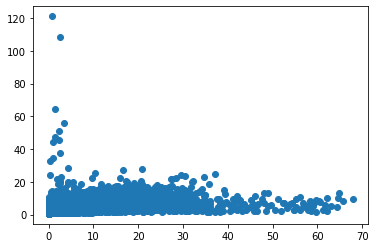

In [103]:
f, a = plt.subplots()
a.scatter(actual, preds)
a.set_ylim()

In [104]:
errors = np.abs((actual - preds))

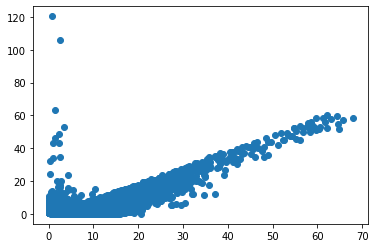

In [106]:
f, a = plt.subplots()
a.scatter(actual, errors)


In [107]:
simple_preds = simple_model.predict(
    x = [hrs_dev[cut_dev], days_dev[cut_dev], X_dev_num[cut_dev], X_dev_neighbors[cut_dev]],
    batch_size = 512,
    verbose = 0
)

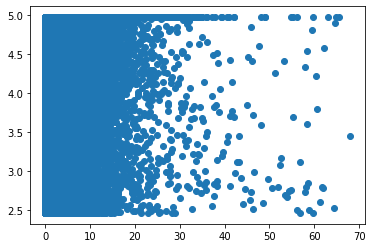

In [108]:
f, a = plt.subplots()
a.scatter(actual, simple_preds)


lol lol lol, every single guess was between 2.5 and 5, what a shitty model

### regular ass L1 regressor

In [35]:
# note this doesn't include imagery
reg_train = np.concatenate((hrs[cut], days[cut], X_train_num[cut], X_train_neighbors[cut]), axis = 1)
rev_dev = np.concatenate((hrs_dev[cut_dev], days_dev[cut_dev], X_dev_num[cut_dev], X_dev_neighbors[cut_dev]), axis = 1)

In [119]:
from sklearn.linear_model import Lasso
l1 = Lasso(alpha = 0.1)
l1.fit(X = reg_train, y = y_train[cut])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [120]:
l1_p = l1.predict(rev_dev)

In [121]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_dev[cut_dev], l1_p)


14.575810238928874

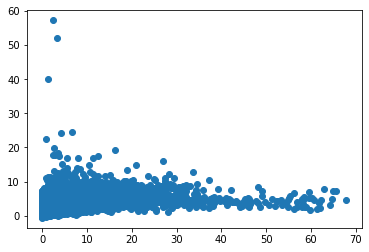

In [125]:
f, a = plt.subplots()
a.scatter(actual,l1_p)

In [135]:
l1.coef_

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.31242121e-01,
       -2.41093438e-03,  5.97927582e-02,  3.31722363e-02, -7.39004409e-03,
       -1.37898512e-04,  1.21533643e-01,  4.44920194e-02,  2.92381878e-02,
        2.59243982e-02,  0.00000000e+00, -5.61240339e-04,  1.11539714e-02,
        0.00000000e+00,  5.70008026e-02,  1.00171383e-01,  1.44733520e-02,
        1.93305536e-01,  1.70418207e-02,  2.49352280e-02,  5.46093417e-02,
       -0.00000000e+00,  

feature indices: 0-23 are hours; 24-30 are days; 31:'epa_pm25_value', 32:'temperature', 33:'humidity', 34:'wind_x', 35:'wind_y', 36: 'ndvi'; 37-60: various neighbor indices

In [136]:
np.argsort(np.abs(l1.coef_))[::-1]

array([31, 48, 37, 60, 56, 46, 57, 33, 45, 51, 38, 34, 59, 58, 39, 40, 50,
       49, 47, 43, 35, 53, 54, 32, 42, 36, 17,  9, 15, 14, 13, 12, 11, 10,
        7,  8,  6,  5,  1,  3,  2,  4, 16, 30, 18, 27, 55, 52, 44, 41, 29,
       28, 26, 19, 25, 24, 23, 22, 21, 20,  0])

In [138]:
for i, v in enumerate(l1.coef_):
    if np.abs(v) > 0.01:
        print(i, v)

31 0.23124212140818923
33 0.05979275817338575
34 0.033172236346551115
37 0.12153364293351411
38 0.04449201939790659
39 0.02923818782998038
40 0.025924398222034795
43 0.011153971446300854
45 0.05700080264896245
46 0.10017138258878527
47 0.01447335200662963
48 0.19330553573046033
49 0.017041820693452288
50 0.024935227962832256
51 0.05460934168066919
56 0.11178567568561286
57 0.09188116205308895
58 0.02973413321874039
59 0.03271180025344263
60 0.12071996054100194


looking at this: 
- time of day is utterly worthless
- epa value seems predictive, followed a few neighbor ones, plus humidity, and, for some reason, wind_x

### fuck it, let's see what features a random forest says are notable

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rf = RandomForestRegressor()
rf.fit(X = reg_train, y = y_train[cut])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
rf_pred = rf.predict(rev_dev)

In [56]:
from sklearn.metrics import mean_squared_error, r2_score


In [42]:

mean_squared_error(y_dev[cut_dev], rf_pred)

6.1489977170239305

## uhh what

In [54]:
actual = y_dev[cut_dev]

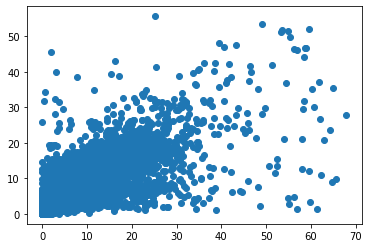

In [45]:
f, a = plt.subplots()
a.scatter(actual,rf_pred)

In [46]:
errors = np.abs((rf_pred - actual))

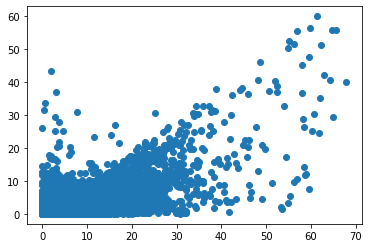

In [47]:
f, a = plt.subplots()
a.scatter(actual,errors)

In [48]:
r2_score(y_dev[cut_dev], rf_pred)

0.6338215768904177

In [51]:
np.argsort(rf.feature_importances_)[::-1]

array([36, 33, 31, 32, 35, 34, 57, 60, 46, 30, 48, 37, 50, 54, 51, 39, 58,
       56, 38, 59, 47, 53, 26, 28, 44, 49, 40, 29, 41, 27, 25, 24, 43, 45,
        3,  2,  4, 16,  0,  5,  1,  6, 15, 52,  8, 17,  7, 42, 55, 18, 23,
       22, 14, 12, 13, 10,  9, 19, 11, 21, 20])

*recall*: feature indices: 0-23 are hours; 24-30 are days; 31:'epa_pm25_value', 32:'temperature', 33:'humidity', 34:'wind_x', 35:'wind_y', 36: 'ndvi'; 37-60: various neighbor indices

so, in this one, ndvi was numero uno, followed by humidity, epa, both wind x and wind y, and then a bunch ofneighbors. time of day/weekday once again shit.

### fuck it, let's try gradient boosted trees

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gbr = GradientBoostingRegressor()
gbr.fit(X = reg_train, y = y_train[cut])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
gb_pred = gbr.predict(rev_dev)

In [57]:
mean_squared_error(actual, gb_pred)

11.244049224407842

In [58]:
r2_score(y_dev[cut_dev], gb_pred)

0.33040661196521937

In [59]:
np.argsort(gbr.feature_importances_)[::-1]

array([36, 33, 31, 57, 60, 37, 48, 30, 32, 46, 50, 51, 56, 38, 47, 40, 54,
       35, 59, 58, 53, 39, 49, 34, 43,  6, 44, 41, 45,  5,  4,  7, 29,  3,
       55, 25,  2, 26, 14,  1,  8,  9, 10, 11, 12, 13, 52, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 27, 28, 42,  0])